In [1]:
import os
import sys
import json
import math

import ROOT

from DevTools.Plotter.style import getStyle
import DevTools.Plotter.CMS_lumi as CMS_lumi
import DevTools.Plotter.tdrstyle as tdrstyle

ROOT.gROOT.SetBatch(ROOT.kTRUE)
ROOT.gROOT.ProcessLine("gErrorIgnoreLevel = 1001;")
tdrstyle.setTDRStyle()
ROOT.gStyle.SetPalette(1)

cmssw_base = os.environ['CMSSW_BASE']

import rootnotes
import rootprint
canvas = rootnotes.default_canvas()

In [2]:
def setStyle(pad,position=11,preliminary=True):
    period_int = 4
    CMS_lumi.wrtieExtraText = preliminary
    CMS_lumi.extraText = "Preliminary"
    CMS_lumi.lumi_13TeV = "%0.1f fb^{-1}" % (float(2318)/1000.)
    CMS_lumi.CMS_lumi(pad,period_int,position)


In [26]:
#%%rootprint

hppFile = '{0}/src/flat/Hpp4l/HPlusPlusHMinusMinusHTo4L_M-500_13TeV-pythia8.root'.format(cmssw_base)
zzFile = '{0}/src/flat/Hpp4l/ZZTo4L_13TeV_powheg_pythia8.root'.format(cmssw_base)
histName = 'default/emem/hppMass'
hpptfile = ROOT.TFile.Open(hppFile,'READ')
zztfile = ROOT.TFile.Open(zzFile,'READ')
hppHist = hpptfile.Get(histName).Rebin(10)
zzHist = zztfile.Get(histName).Rebin(10)

stack = ROOT.THStack('stack','stack')
stack.Add(zzHist)
#stack.Add(hppHist)

hist = stack.GetStack().Last()

hist.GetXaxis().SetTitle('m_{l^{+}l^{+}} (GeV)')
hist.GetYaxis().SetTitle('Events / 10.0 GeV')

w = ROOT.RooWorkspace()
w.factory('Exponential::bg1(x[100,1200],decay1[-1.,0])')
w.factory('Exponential::bg2(x,decay2[-1.,0])')
#w.factory('RooVoigtian::sig(x,mean[480,520],width[0,50],sigma[0,1])')
#w.factory('RooCBShape::sig(x,mean[480,520],sigma[0,25],a[0,100],n[0,100])')
#w.factory('SUM::model(bg1scale[0,100]*bg1,bg2scale[0,100]*bg2,sigscale[0,100]*sig)')
w.factory('SUM::model(bg1scale[0,100]*bg1,bg2scale[0,100]*bg2)')


x = w.var('x')
model = w.pdf('model')
x.setRange('low',100,450)
x.setRange('high',550,1200)
x.setRange('sigRange',450,550)
x.setRange('all',100,1200)

frame = x.frame()

datahist = ROOT.RooDataHist('d','d',ROOT.RooArgList(x),hist)
datahist.plotOn(frame)

#model.fitTo(datahist,ROOT.RooFit.Save())
model.fitTo(datahist,ROOT.RooFit.Save(),ROOT.RooFit.Range('low,high'))
model.plotOn(frame,ROOT.RooFit.Range('all'))
model.plotOn(frame,ROOT.RooFit.Range('all'),ROOT.RooFit.Components('bg1'),ROOT.RooFit.LineColor(ROOT.kGreen))
model.plotOn(frame,ROOT.RooFit.Range('all'),ROOT.RooFit.Components('bg2'),ROOT.RooFit.LineColor(ROOT.kMagenta))
#model.plotOn(frame,ROOT.RooFit.Range('all'),ROOT.RooFit.Components('sig'),ROOT.RooFit.LineColor(ROOT.kRed))

#frame.Draw()

hist.SetMarkerStyle(20)
hist.SetMarkerSize(1)
hist.Draw("e0")
hist.SetMaximum(100)
fit = frame.getObject(1)
bg1plot = frame.getObject(2)
bg2plot = frame.getObject(3)
#sigplot = frame.getObject(4)

bg1plot.Draw("same")
bg2plot.Draw("same")
#sigplot.Draw("same")
fit.Draw("same")

setStyle(canvas)



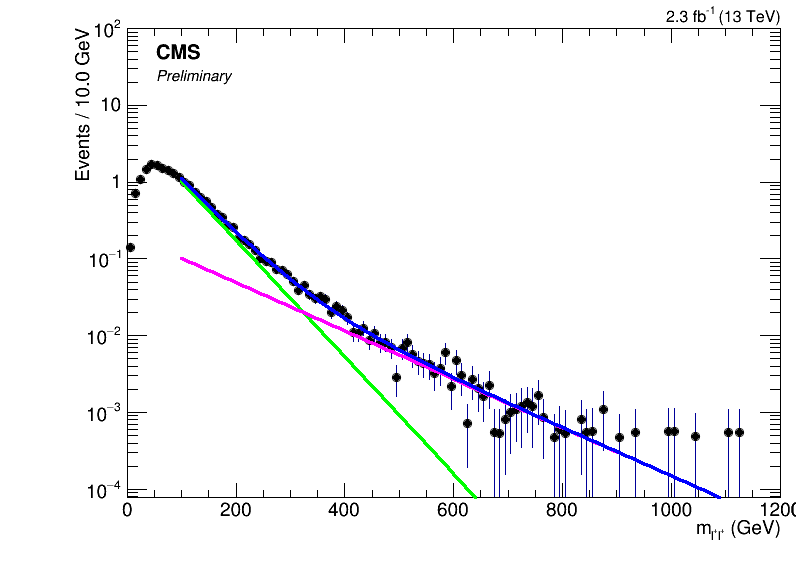

In [27]:
canvas.SetLogy(1)
canvas

In [81]:
# load fiducial
masses = [200,300,400,500,600,700,800,900,1000]
genChannels = []
higgsChannels = ['ee','em','et','mm','mt','tt']
for hpp in higgsChannels:
    for hmm in higgsChannels:
        genChannels += [hpp+hmm]

fiducials = {}
decays = {}
preselection = {}
for chan in genChannels:
    fiducials[chan] = []
    decays[chan] = []
    preselection[chan] = []

for mass in masses:
    genfile = '{0}/src/jsons/Hpp4l/genCounts.{1}.json'.format(cmssw_base, mass)
    recofile = '{0}/src/jsons/Hpp4l/recoCounts.{1}.json'.format(cmssw_base, mass)
    with open(genfile) as f:
        gen = json.load(f)
    with open(recofile) as f:
        reco = json.load(f)
    for chan in genChannels:
        fiducials[chan] += [gen['fiducial'][chan]]
        decays[chan] += [gen['decay'][chan]]
        preselection[chan] += [reco['preselection'][chan]]


In [116]:
cats = ['I','II','III','IV','V','VI']
colors = {
    'I'  : ROOT.kRed,
    'II' : ROOT.kRed+1,
    'III': ROOT.kRed+2,
    'IV' : ROOT.kBlue+2,
    'V'  : ROOT.kBlue+1,
    'VI' : ROOT.kBlue,
}
accHists = {}
effHists = {}
accFits = {}
effFits = {}
func = 'tanh([0]*x+[1])+[2]'
for cat in cats:
    accHists[cat] = ROOT.TH1F('ah{0}'.format(cat),'Cat. {0}'.format(cat),9,150,1050)
    effHists[cat] = ROOT.TH1F('eh{0}'.format(cat),'Cat. {0}'.format(cat),9,150,1050)
    accFits[cat] = ROOT.TF1('acc{0}'.format(cat),func,100,1500)
    effFits[cat] = ROOT.TF1('eff{0}'.format(cat),func,100,1500)
    for i in range(len(masses)):
        if cat=='I':
            chans = [chan for chan in genChannels if chan.count('t')==0]
        if cat=='II':
            chans = [chan for chan in genChannels if chan.count('t')==1]
        if cat=='III':
            chans = [chan for chan in genChannels if (chan.count('t')==2 and (chan[:2]=='tt' or chan[2:]=='tt'))]
        if cat=='IV':
            chans = [chan for chan in genChannels if (chan.count('t')==2 and not (chan[:2]=='tt' or chan[2:]=='tt'))]
        if cat=='V':
            chans = [chan for chan in genChannels if chan.count('t')==3]
        if cat=='VI':
            chans = [chan for chan in genChannels if chan.count('t')==4]
        fids = sum([fiducials[chan][i] for chan in chans])
        decs = sum([decays[chan][i] for chan in chans])
        pres = sum([preselection[chan][i] for chan in chans])
        acc = float(fids)/decs if decs else 0.
        eff = float(pres)/fids if fids else 0.
        accErr = acc * (float(fids)/fids**2+float(decs)/decs**2)**0.5
        effErr = acc * (float(pres)/pres**2+float(fids)/fids**2)**0.5
        accHists[cat].SetBinContent(i+1,acc)
        accHists[cat].SetBinError(i+1,accErr)
        effHists[cat].SetBinContent(i+1,eff)
        effHists[cat].SetBinError(i+1,effErr)
    accHists[cat].Fit('acc{0}'.format(cat))
    effHists[cat].Fit('eff{0}'.format(cat))
    # styling
    accHists[cat].SetLineColor(colors[cat])
    accHists[cat].SetMarkerColor(colors[cat])
    effHists[cat].SetLineColor(colors[cat])
    effHists[cat].SetMarkerColor(colors[cat])
    accFits[cat].SetLineColor(colors[cat])
    accFits[cat].SetMarkerColor(colors[cat])
    effFits[cat].SetLineColor(colors[cat])
    effFits[cat].SetMarkerColor(colors[cat])


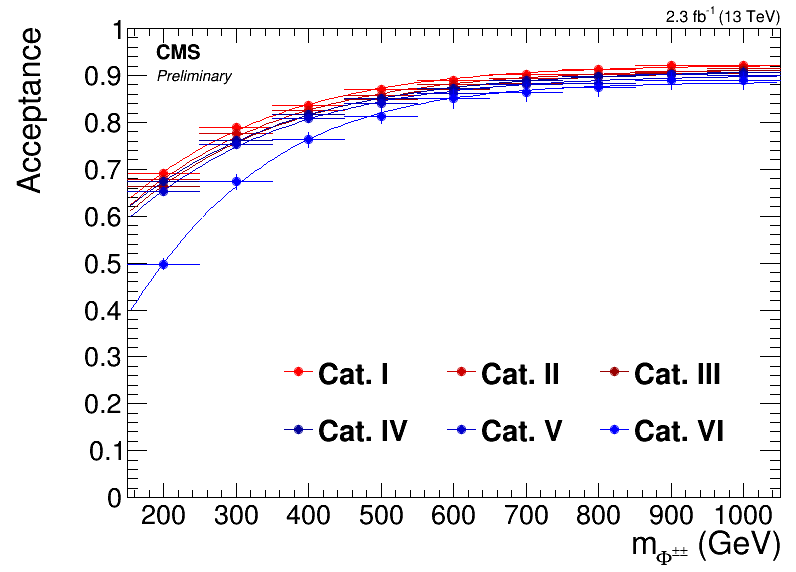

In [122]:
legend = ROOT.TLegend(0.35,0.2,0.95,0.4,'','NDC')
legend.SetNColumns(3)

for cat in cats:
    if cat==cats[0]:
        accHists[cat].Draw('p')
        accHists[cat].GetXaxis().SetTitle('m_{#Phi^{#pm#pm}} (GeV)')
        accHists[cat].GetYaxis().SetTitle('Acceptance')
        accHists[cat].SetMaximum(1.)
        accHists[cat].SetMinimum(0.)
    else:
        accHists[cat].Draw('psame')
    legend.AddEntry(accHists[cat])
    accFits[cat].Draw('same')
legend.Draw('same')
setStyle(canvas)
ROOT.gStyle.SetOptFit(0)

canvas

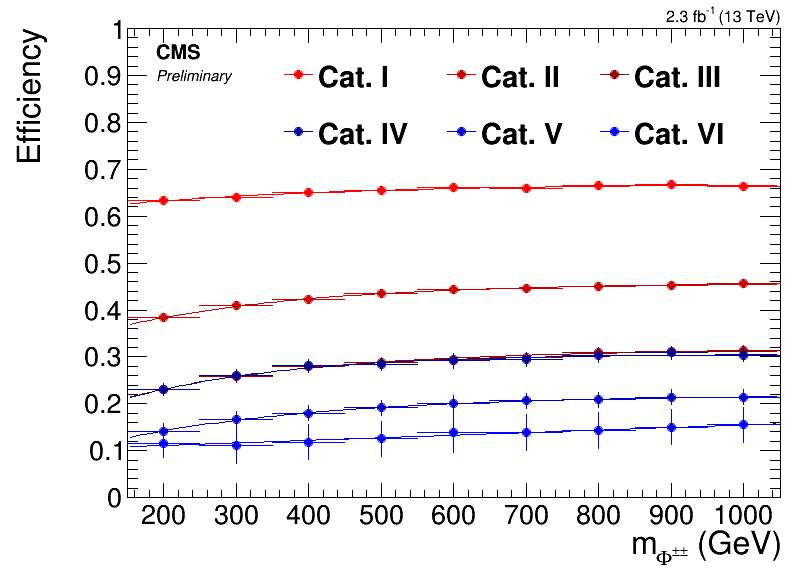

In [121]:
legend = ROOT.TLegend(0.35,0.72,0.95,0.92,'','NDC')
legend.SetNColumns(3)

for cat in cats:
    if cat==cats[0]:
        effHists[cat].Draw('p')
        effHists[cat].GetXaxis().SetTitle('m_{#Phi^{#pm#pm}} (GeV)')
        effHists[cat].GetYaxis().SetTitle('Efficiency')
        effHists[cat].SetMaximum(1.)
        effHists[cat].SetMinimum(0.)
    else:
        effHists[cat].Draw('psame')
    effFits[cat].Draw('same')
    legend.AddEntry(effHists[cat])
setStyle(canvas)
legend.Draw('same')
ROOT.gStyle.SetOptFit(0)

canvas